# Torus Detection via Latent Cosine Similarity

This notebook loads the trained GAT point cloud autoencoder, generates rotation/scale augmentations of each shape in `point_cloud_data/pointcloud_shapes_v1`, builds latent embeddings with the encoder, and classifies whether a sample is a torus using cosine similarity to a torus prototype latent.

Workflow:
1. Load checkpoint & model (encoder part of the autoencoder).
2. Enumerate all *.npy shapes; choose 'torus_surface' as positive class.
3. For each shape, create multiple random SO(3) rotations and scalings, encode to latent (mean-pooled).
4. Build a torus prototype (mean latent over torus augmentations).
5. Compute cosine similarities of all augmented samples to prototype.
6. Select decision threshold maximizing F1 (scan over candidate thresholds).
7. Report metrics & visualize similarity distributions and ROC.
8. Provide a helper cell to classify an arbitrary new point cloud file.

You can adjust augmentation counts, rotation mode, scaling range, and threshold strategy below.

In [17]:
# Section 1: Imports & Configuration
import os, math, json, random, sys
from pathlib import Path
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Optional dependencies (silently skipped if unavailable)
try:
    from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, classification_report
except Exception:
    roc_curve = auc = precision_recall_fscore_support = classification_report = None
try:
    import pandas as pd
except Exception:
    pd = None

# Ensure project root in path
ROOT = Path(os.getcwd()).resolve()
if str(ROOT) not in sys.path: sys.path.insert(0, str(ROOT))

from models.gat_autoencoder import GATPointCloudAutoencoder  # noqa: E402
from train import build_knn_graph, random_so3_matrix  # noqa: E402

# Paths / parameters (edit as needed)
DATA_DIR = Path('point_cloud_data/pointcloud_shapes_v1')
CHECKPOINT_PATH = Path('runs/so3_scale_run/best.pt')  # adjust to your run
OUTPUT_DIR = Path('evaluation_outputs'); OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Augmentation controls
N_AUG = 20              # number of augmented samples per original file
ROTATION_MODE = 'so3'   # 'so3' for full 3D, 'z' for axial
SCALE_MIN, SCALE_MAX = 0.2, 2.
APPLY_JITTER = False
JITTER_STD = 0.005

# Graph / model inference
K_NEIGHBORS = 16         # will fallback to checkpoint value if provided
POSITIVE_SHAPE_NAME = 'torus_surface'  # substring or exact stem identifying torus

random.seed(42); np.random.seed(42); torch.manual_seed(42)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(42)
print('Device:', DEVICE)

Device: cpu


In [18]:
# Section 2: Load Checkpoint & Instantiate Model
assert CHECKPOINT_PATH.exists(), f'Checkpoint not found: {CHECKPOINT_PATH}'
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
cfg = ckpt.get('cfg', {})
latent_dim_ckpt = cfg.get('latent_dim', 64)
in_channels = cfg.get('in_channels', 3)
hidden_dims = cfg.get('hidden_dims', (64,128))
heads = cfg.get('heads', 4)
dropout = cfg.get('dropout', 0.1)
decode_hidden = cfg.get('decode_hidden', (128,))
K_NEIGHBORS = cfg.get('k', K_NEIGHBORS)
model = GATPointCloudAutoencoder(in_channels=in_channels, hidden_dims=hidden_dims, latent_dim=latent_dim_ckpt, heads=heads, dropout=dropout, decode_hidden_dims=decode_hidden).to(DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()
print('Loaded model with latent_dim =', latent_dim_ckpt)

Loaded model with latent_dim = 8


In [19]:
# Section 3: Utility Functions (augmentation & encoding)
def z_axis_rotation_matrix(device):
    theta = torch.rand((), device=device) * (2 * math.pi)
    c, s = torch.cos(theta), torch.sin(theta)
    R = torch.zeros(3,3, device=device)
    R[0,0]=c; R[0,1]=-s; R[1,0]=s; R[1,1]=c; R[2,2]=1.0
    return R

def apply_augment(pts: torch.Tensor) -> torch.Tensor:
    # pts: (N, D) torch float32
    out = pts.clone()
    center = out[:, :3].mean(0, keepdim=True)
    if ROTATION_MODE == 'so3':
        R = random_so3_matrix(out.device)
    elif ROTATION_MODE == 'z':
        R = z_axis_rotation_matrix(out.device)
    else:
        R = torch.eye(3, device=out.device)
    out_xyz = out[:, :3] - center
    out[:, :3] = (R @ out_xyz.T).T + center
    scale = torch.empty(1, device=out.device).uniform_(SCALE_MIN, SCALE_MAX)
    out[:, :3] = (out[:, :3] - center) * scale + center
    if APPLY_JITTER and JITTER_STD > 0:
        out = out + torch.randn_like(out) * JITTER_STD
    return out

@torch.no_grad()
def encode_point_cloud(arr: np.ndarray) -> torch.Tensor:
    # arr shape (N,D)
    pts = torch.from_numpy(arr.astype(np.float32)).to(DEVICE)
    # augment
    pts_aug = apply_augment(pts)
    edge_index = build_knn_graph(pts_aug[:, :3], k=K_NEIGHBORS).to(DEVICE)
    _, z = model(pts_aug, edge_index)
    # mean pool nodes -> global latent
    return z.mean(0)  # (latent_dim,)

In [20]:
# Section 4: Load Point Cloud Files
assert DATA_DIR.exists() and DATA_DIR.is_dir(), f'Data directory missing: {DATA_DIR}'
pc_files = sorted([p for p in DATA_DIR.glob('*.npy')])
assert pc_files, 'No .npy files found.'
print('Found', len(pc_files), 'files')
for p in pc_files: print(' -', p.name)

Found 9 files
 - cone_surface.npy
 - cube_surface.npy
 - cylinder_surface.npy
 - disk.npy
 - pyramid_square_surface.npy
 - sphere_surface.npy
 - square_plane.npy
 - torus_surface.npy
 - triangle_eq.npy


In [21]:
# Section 5: Generate Augmented Latents for Each Shape
all_latents = []  # list of tensors (latent_dim,)
all_labels = []   # 1 if torus, else 0
all_shapes = []   # shape name per latent
shape_to_latents = {}  # dict for prototype computation

for f in pc_files:
    arr = np.load(f)
    if arr.ndim == 3:  # take first if batched
        arr = arr[0]
    assert arr.ndim == 2, f'Unexpected shape for {f.name}: {arr.shape}'
    lat_list = []
    for i in range(N_AUG):
        lat = encode_point_cloud(arr)
        lat_list.append(lat.cpu())
        all_latents.append(lat.cpu())
        all_shapes.append(f.stem)
        label = 1 if POSITIVE_SHAPE_NAME in f.stem else 0
        all_labels.append(label)
    shape_to_latents[f.stem] = torch.stack(lat_list, dim=0)
print('Completed latent generation.')
print('Total augmented samples:', len(all_latents))

Completed latent generation.
Total augmented samples: 180


In [22]:
# Section 6: Build Torus Prototype Latent
assert any(POSITIVE_SHAPE_NAME in s for s in shape_to_latents.keys()), 'Torus shape not found. Adjust POSITIVE_SHAPE_NAME.'
torus_keys = [k for k in shape_to_latents if POSITIVE_SHAPE_NAME in k]
torus_latents = torch.cat([shape_to_latents[k] for k in torus_keys], dim=0)
prototype = torus_latents.mean(0)  # (latent_dim,)
print('Torus prototype vector norm:', prototype.norm().item())
print('Torus augmentations used:', torus_latents.shape[0])

Torus prototype vector norm: 0.15229491889476776
Torus augmentations used: 20


In [23]:
# Section 7: Cosine Similarity Scores
lat_matrix = torch.stack(all_latents, dim=0)  # (M, latent_dim)
proto_norm = prototype / (prototype.norm() + 1e-8)
scores = F.linear(lat_matrix, proto_norm.unsqueeze(0))  # cosine since proto is normalized, but need to normalize latents too
lat_norms = lat_matrix / (lat_matrix.norm(dim=1, keepdim=True) + 1e-8)
cos_scores = (lat_norms * proto_norm).sum(dim=1).cpu().numpy()
labels_np = np.array(all_labels)
shapes_np = np.array(all_shapes)
print('Score stats: min={:.4f} max={:.4f} mean={:.4f}'.format(cos_scores.min(), cos_scores.max(), cos_scores.mean()))

Score stats: min=0.0429 max=0.9996 mean=0.6623


In [24]:
# Section 8: Threshold Selection (maximize F1)
def compute_metrics(preds, labels):
    tp = ((preds == 1) & (labels == 1)).sum()
    fp = ((preds == 1) & (labels == 0)).sum()
    fn = ((preds == 0) & (labels == 1)).sum()
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2*precision*recall / (precision + recall + 1e-8)
    return precision, recall, f1, tp, fp, fn

thr_candidates = np.linspace(cos_scores.min(), cos_scores.max(), 400)
best = {'f1': -1, 'thr': None, 'precision': None, 'recall': None}
for thr in thr_candidates:
    preds = (cos_scores >= thr).astype(int)
    precision, recall, f1, tp, fp, fn = compute_metrics(preds, labels_np)
    if f1 > best['f1']:
        best = {'f1': f1, 'thr': thr, 'precision': precision, 'recall': recall}

print('Best threshold {:.4f} | F1 {:.4f} | Precision {:.4f} | Recall {:.4f}'.format(best['thr'], best['f1'], best['precision'], best['recall']))
best_threshold = best['thr']
best

Best threshold 0.9348 | F1 1.0000 | Precision 1.0000 | Recall 1.0000


{'f1': 0.9999999945,
 'thr': 0.9348270707112506,
 'precision': 0.9999999995,
 'recall': 0.9999999995}

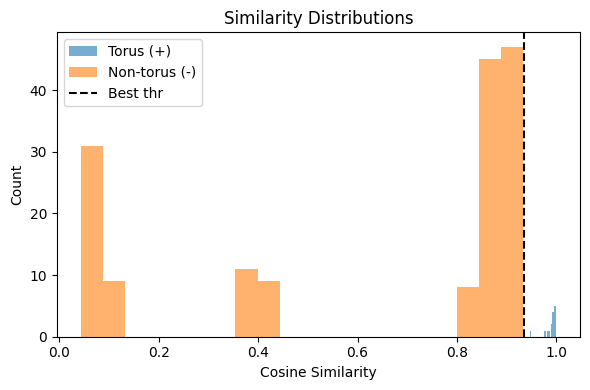

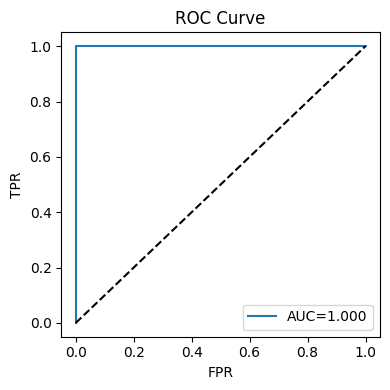

In [25]:
# Section 9: Visualization of Score Distributions & ROC (if sklearn available)
pos_scores = cos_scores[labels_np==1]
neg_scores = cos_scores[labels_np==0]
plt.figure(figsize=(6,4))
plt.hist(pos_scores, bins=20, alpha=0.6, label='Torus (+)', color='tab:blue')
plt.hist(neg_scores, bins=20, alpha=0.6, label='Non-torus (-)', color='tab:orange')
plt.axvline(best_threshold, color='k', linestyle='--', label='Best thr')
plt.xlabel('Cosine Similarity'); plt.ylabel('Count'); plt.title('Similarity Distributions')
plt.legend(); plt.tight_layout(); plt.show()

if roc_curve is not None:
    fpr, tpr, _ = roc_curve(labels_np, cos_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print('sklearn not available; skipping ROC plot.')

In [26]:
# Section 10: Detailed Classification Report (if sklearn)
if classification_report is not None:
    preds_best = (cos_scores >= best_threshold).astype(int)
    print(classification_report(labels_np, preds_best, target_names=['non_torus','torus']))
else:
    print('sklearn not available; raw counts:', best)

              precision    recall  f1-score   support

   non_torus       1.00      1.00      1.00       160
       torus       1.00      1.00      1.00        20

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [14]:
# Section 11: Results Table (optional pandas)
preds_best = (cos_scores >= best_threshold).astype(int)
if pd is not None:
    df = pd.DataFrame({'shape': shapes_np, 'label': labels_np, 'score': cos_scores, 'pred': preds_best})
    display(df.head())
else:
    print('Pandas not installed; showing first 5 samples:')
    for i in range(min(5, len(cos_scores))):
        print(shapes_np[i], labels_np[i], cos_scores[i], preds_best[i])

,shape,label,score,pred
0,cone_surface,0,0.054433,0
1,cone_surface,0,0.051732,0
2,cone_surface,0,0.054325,0
3,cone_surface,0,0.059331,0
4,cone_surface,0,0.049190,0


In [15]:
# Section 12: Save Artifacts
results = {
    'checkpoint': str(CHECKPOINT_PATH),
    'latent_dim': int(latent_dim_ckpt),
    'positive_shape_name': POSITIVE_SHAPE_NAME,
    'n_aug': N_AUG,
    'rotation_mode': ROTATION_MODE,
    'scale_range': [SCALE_MIN, SCALE_MAX],
    'k_neighbors': int(K_NEIGHBORS),
    'best_threshold': float(best_threshold),
    'best_metrics': best,
}
with open(OUTPUT_DIR / 'torus_similarity_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print('Saved results to', OUTPUT_DIR / 'torus_similarity_results.json')

Saved results to evaluation_outputs\torus_similarity_results.json


In [16]:
# Section 13: Helper - Classify a New Point Cloud File
NEW_FILE_PATH = None  # e.g., Path('some_new_cloud.npy')
if NEW_FILE_PATH is not None:
    p = Path(NEW_FILE_PATH); assert p.exists(), f'File not found: {p}'
    arr = np.load(p)
    if arr.ndim == 3: arr = arr[0]
    lat = encode_point_cloud(arr)
    lat_norm = lat / (lat.norm() + 1e-8)
    score = torch.dot(lat_norm, prototype / (prototype.norm()+1e-8)).item()
    pred = int(score >= best_threshold)
    print(f'File: {p.name} | Cosine={score:.4f} | Predicted Torus={bool(pred)}')
else:
    print('Set NEW_FILE_PATH to classify a new sample.')

Set NEW_FILE_PATH to classify a new sample.
